In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [2]:
EPOCHS = 30
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [3]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),  # Resize the image to 256x256 pixels
            transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])
        
    # If the phase is VAL
    if phase == VAL:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    # If the phase is TEST
    if phase == TEST:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform  # Return the composed transformations

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


In [4]:
# Create a dictionary of datasets for each phase (TRAIN, VAL, TEST)
# For each phase, load the images from the corresponding folder and apply the data transformations
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

# Create a dictionary of dataloaders for each phase
# For each phase, create a DataLoader that loads the data from the corresponding dataset
# The batch size and shuffle parameters can be adjusted as needed
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 4, shuffle=True), 
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)
}

In [5]:
# Get the sizes of the datasets
dataset_sizes = {
    x: len(image_datasets[x]) 
    for x in [TRAIN, VAL]
}

# Get the classes from the training dataset
classes = image_datasets[TRAIN].classes

# Get the class names from the training dataset
class_names = image_datasets[TRAIN].classes

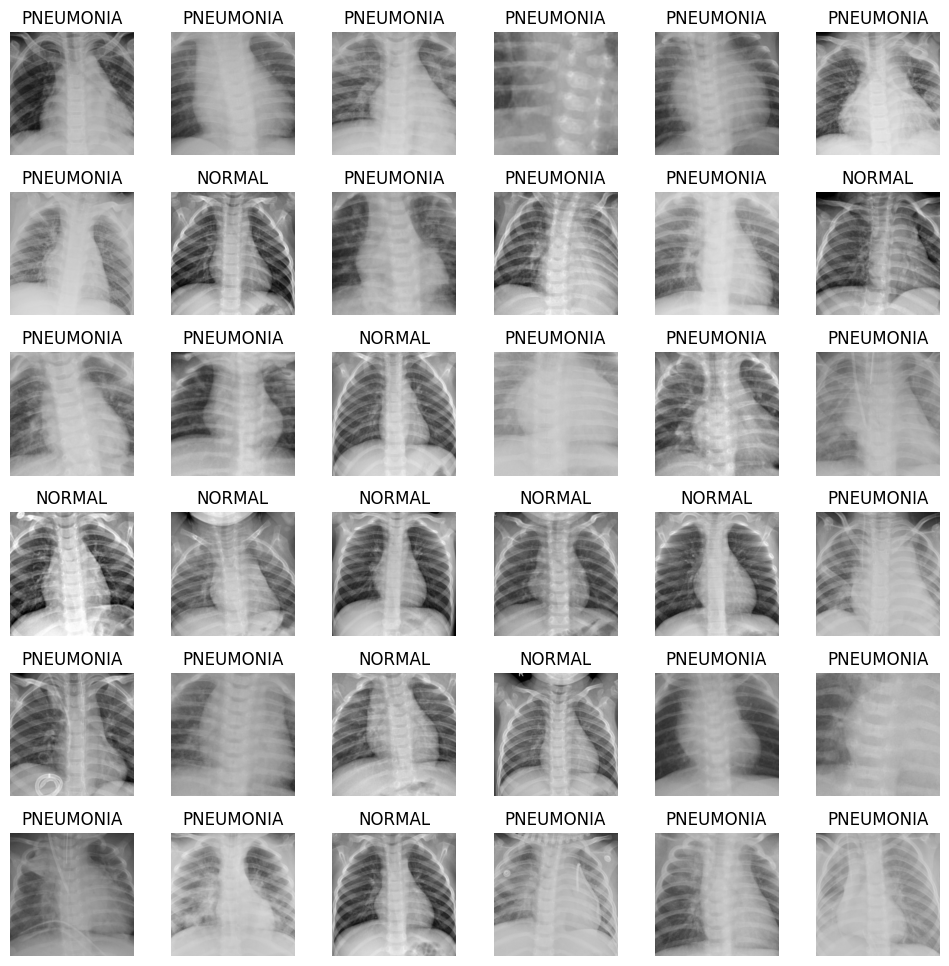

In [6]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(6):
    for j in range(6):
        inputs, classes = next(iter(dataloaders[TRAIN]))
        input_img = inputs[0]
        class_label = classes[0]
        inp = input_img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        axes[i, j].imshow(inp)
        axes[i, j].set_title(class_names[class_label.item()])
        axes[i, j].axis('off')

plt.show()

In [8]:
inputs, classes = next(iter(dataloaders[TRAIN]))

In [19]:
import matplotlib.pyplot as plt

import time

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / total_samples

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == TRAIN:
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
        
        end_time = time.time()  # Record end time for the epoch
        epoch_time = end_time - start_time  # Calculate epoch training time
        print("Epoch training time: {:.2f} seconds".format(epoch_time))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # Plotting accuracy
    plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

    return model


In [20]:
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load("../input/pytorch-pretrained-models/vgg16-397923af.pth"))

<All keys matched successfully>

In [21]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [23]:
EPOCHS=10

Epoch 1/10
train Loss: 0.2970 Acc: 0.8831
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 157.09 seconds
Epoch 2/10
train Loss: 0.2896 Acc: 0.8875
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 156.18 seconds
Epoch 3/10
train Loss: 0.2924 Acc: 0.8819
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 156.55 seconds
Epoch 4/10
train Loss: 0.2954 Acc: 0.8869
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 157.21 seconds
Epoch 5/10
train Loss: 0.2927 Acc: 0.8855
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 157.26 seconds
Epoch 6/10
train Loss: 0.2931 Acc: 0.8882
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 156.59 seconds
Epoch 7/10
train Loss: 0.2952 Acc: 0.8852
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 156.25 seconds
Epoch 8/10
train Loss: 0.2954 Acc: 0.8823
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 157.23 seconds
Epoch 9/10
train Loss: 0.2911 Acc: 0.8842
val Loss: 0.4984 Acc: 0.6875
Epoch training time: 156.62 seconds
Epoch 10/10
train Loss: 0.2942 Acc: 0

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

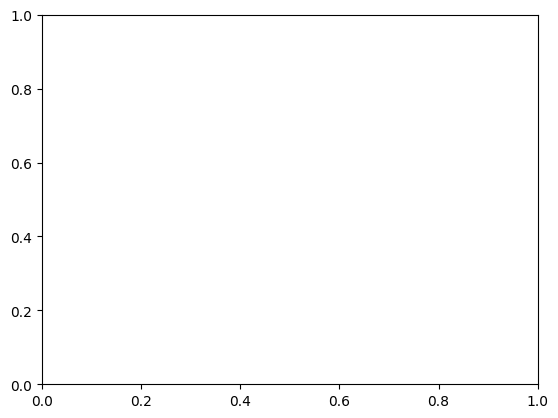

In [24]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [27]:
def test_model():
    # Initialize counters
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    input_images = []
    
    epoch_cnt = 0
    # No need to track gradients for testing
    with torch.no_grad():
        # Iterate over test data
        print("Epoch:", epoch_cnt)
        epoch_cnt += 1
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Store true labels
            true_labels.append(labels.item())
            
            #Store model input images
            input_images.append(inputs)
            
            # Forward pass
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)

            # Store predicted labels
            pred_labels.append(preds.item())

            # Update counters
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

        # Calculate accuracy
        acc = running_correct / running_total

    return true_labels, pred_labels, input_images,  running_correct, running_total, acc


In [28]:
res = test_model()

Epoch: 0


In [29]:
true_labels, pred_labels, input_images, running_correct, running_total, acc = test_model()

Epoch: 0


In [31]:
fig.subplots_adjust(hspace=0.7, wspace=0.7)
x=0
for i in range(3):
    for j in range(3):
        # Get the image and labels
        inp = input_images[x].squeeze()
      
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()